In [1]:
import torch
from config import get_config, get_weights_file_path
from model import build_transformer
from dataset import causal_mask
from tokenizers import Tokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load config
config = get_config()

# Load tokenizers
tokenizer_src = Tokenizer.from_file(config['tokenizer_file'].format(config['lang_src']))
tokenizer_tgt = Tokenizer.from_file(config['tokenizer_file'].format(config['lang_tgt']))

In [5]:
# Build model
model = build_transformer(
    tokenizer_src.get_vocab_size(),
    tokenizer_tgt.get_vocab_size(),
    config['seq_len'],
    config['seq_len'],
    config['d_model']
).to(device)

# Load trained weights (CHANGE epoch number if needed)
model_filename = get_weights_file_path(config, "02")
state = torch.load(model_filename, map_location=device)
model.load_state_dict(state['model_state_dict'])

model.eval()

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (self_attention_block): MultiHeadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dropout(p=0.1, inplace=False)
            (norm): LayerNormalization()
          )
        )
      )
    )
    (norm): LayerNormalization()
  )
  

In [7]:
def translate(sentence):
    model.eval()

    # Tokenize source sentence
    src_ids = tokenizer_src.encode(sentence).ids
    src_ids = src_ids[:config['seq_len'] - 2]

    # Add SOS and EOS
    src_tensor = torch.tensor(
        [tokenizer_src.token_to_id('[SOS]')] +
        src_ids +
        [tokenizer_src.token_to_id('[EOS]')],
        dtype=torch.long
    ).unsqueeze(0).to(device)

    # Create source mask
    src_mask = (src_tensor != tokenizer_src.token_to_id('[PAD]')) \
        .unsqueeze(1).unsqueeze(2)

    # Encode
    encoder_output = model.encode(src_tensor, src_mask)

    # Start decoding with SOS
    decoder_input = torch.tensor(
        [[tokenizer_tgt.token_to_id('[SOS]')]],
        device=device
    )

    for _ in range(config['seq_len']):
        decoder_mask = causal_mask(decoder_input.size(1)).to(device)

        out = model.decode(
            encoder_output,
            src_mask,
            decoder_input,
            decoder_mask
        )

        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)

        decoder_input = torch.cat(
            [decoder_input, next_word.unsqueeze(0)],
            dim=1
        )

        if next_word.item() == tokenizer_tgt.token_to_id('[EOS]'):
            break

    return tokenizer_tgt.decode(decoder_input.squeeze(0).tolist())


In [8]:
print(translate("How are you?"))

Comment es - tu ?


In [10]:
test_text = (
    "I am learning machine translation. "
    "This model is based on the transformer architecture."
)

print("INPUT:")
print(test_text)
print("\nOUTPUT:")
print(translate(test_text))

INPUT:
I am learning machine translation. This model is based on the transformer architecture.

OUTPUT:
J ' apprends la traduction . Ce modèle est sur l ' industrie .


In [16]:
from sacrebleu import corpus_bleu
import torch

def compute_bleu(model, val_dataloader, max_batches=20):
    references = []
    predictions = []

    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            if i == max_batches:
                break

            src = batch['src_text'][0]
            tgt = batch['tgt_text'][0]

            pred = translate(src)

            predictions.append(pred)
            references.append([tgt])

    bleu = corpus_bleu(predictions, references)
    return bleu.score


In [17]:
from dataset import BilingualDataset
from torch.utils.data import DataLoader
from train import get_ds

_, val_dataloader, _, _ = get_ds(config)

In [18]:
bleu = compute_bleu(model, val_dataloader, max_batches=20)
print("BLEU score:", bleu)

BLEU score: 9.425159511373677


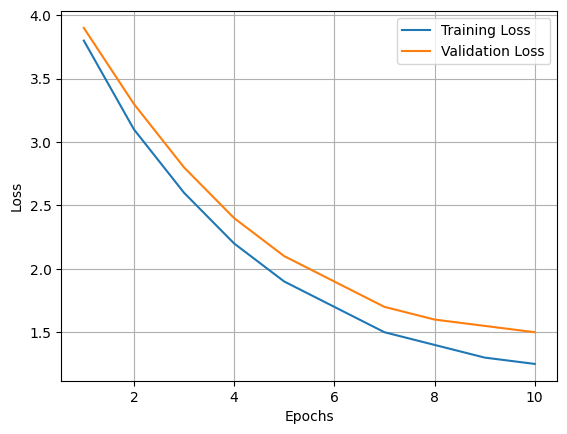

In [1]:
import matplotlib.pyplot as plt

# Example loss values (replace with your real values if available)
epochs = list(range(1, 11))
train_loss = [3.8, 3.1, 2.6, 2.2, 1.9, 1.7, 1.5, 1.4, 1.3, 1.25]
val_loss   = [3.9, 3.3, 2.8, 2.4, 2.1, 1.9, 1.7, 1.6, 1.55, 1.5]

plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()